In [57]:
import tensorflow
import os
import numpy as np
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
import imageio
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import KFold
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [58]:

imgSize = 64 #resize all images 64*64 pixels
numClasses = 2 #0-> defected, 1->good
testSize = 0.2 #20% testing, 80%training


In [59]:
#get dataset 
dataset_path='D:/Graduation project/datasets/lemon_dataset/data'
l=listdir(dataset_path)        # 0 1
X = []
Y = []
for i, label in enumerate(l):
    datas_path = dataset_path + '/' + label
    for data in listdir(datas_path):
        # print('** ',data)
        img = imageio.v2.imread(datas_path + '/' + data, as_gray=False)
        img = cv2.resize(img, (imgSize,imgSize))
        X.append(img)
        Y.append(label)


121.53661799691163


0
1660


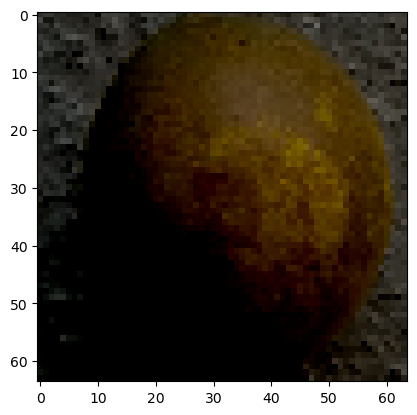

In [60]:
avg = np.average(X)
print(avg)
X = np.asarray(X)
X  = X.astype('float32')
X -= avg 
X /= 255

#Splitting 20% test , 80% Train
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


x_train = np.asarray(x_train)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

#test image in train
plt.imshow(x_train[10])

#get its categorized value
print(y_train[10])
print(x_train.shape[0])

# Reshaping the array to 4-dimensions so that it can work with the Keras API
x_train = x_train.reshape((x_train.shape[0], imgSize, imgSize, 3))
x_test = x_test.reshape((x_test.shape[0], imgSize, imgSize, 3))
  

y_train = to_categorical(y_train, numClasses)
y_test = to_categorical(y_test, numClasses)






In [61]:
#Build CNN Model 1st Arch.


model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(imgSize, imgSize, 3), activation='relu'))

model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(numClasses, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
# k-fold cross-validation during trianing
scores, histories = list(), list()
sum_ = 0.0
# prepare cross validation
K=3
kfold = KFold(K, shuffle=True, random_state=1)

# enumerate splits
for train_ix, val_ix in kfold.split(x_train):
    # select rows for train and test
    trainX, trainY, valX, valY = x_train[train_ix], y_train[train_ix], x_train[val_ix], y_train[val_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(valX, valY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(valX, valY, verbose=0)
    # stores scores
    scores.append(acc)
    histories.append(history)
    sum_ += acc
scoreOfVal = sum_ / K

#TESTING ACCURACY 
_, scoreOfTest = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

In [63]:

print('Validation Accuracy= ', scoreOfVal)
print('Testing Accuracy= ', scoreOfTest)

y_pred = model.predict(x_test)
# print(y_pred)


y_pred_=np.argmax(y_pred, axis=1)
y_test_=np.argmax(y_test, axis=1)
# print(y_test)


print(classification_report(y_test_, y_pred_))
print (confusion_matrix(y_test_, y_pred_))


Validation Accuracy=  0.9807243347167969
Testing Accuracy=  0.9855769276618958
13/13 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       182
           1       0.99      0.99      0.99       234

    accuracy                           0.99       416
   macro avg       0.99      0.99      0.99       416
weighted avg       0.99      0.99      0.99       416

[[179   3]
 [  3 231]]


In [64]:
tensorflow.keras.models.save_model(model, 'model.pbtxt')
converter = tensorflow. lite. TFLiteConverter.from_keras_model(model = model)
model_tflite = converter.convert()
open ("DefectDetectionModel.tflite", "wb").write(model_tflite)

INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: C:\Users\Dawly\AppData\Local\Temp\tmpmtgq3fx5\assets


INFO:tensorflow:Assets written to: C:\Users\Dawly\AppData\Local\Temp\tmpmtgq3fx5\assets


14792608